<a href="https://colab.research.google.com/github/UITTrinhQuangTruong/CS114.K21/blob/master/%C4%90%E1%BB%93_%C3%A1n_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Đổi tên hàng loạt

In [ ]:
#254 Cobaoluc
#272 Khongbaoluc
!/bin/sh '/content/drive/My Drive/Machine Lol/Data/rename.sh'

^C


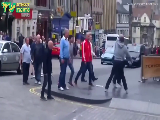

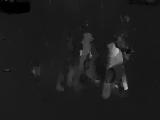

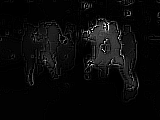

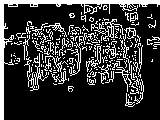

3


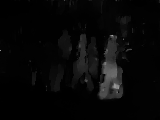

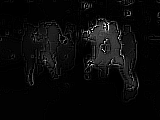

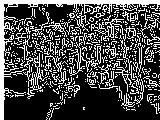

6


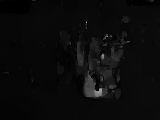

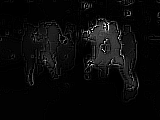

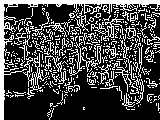

9


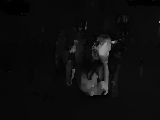

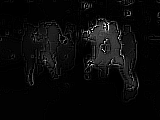

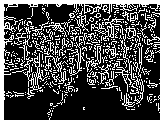

12


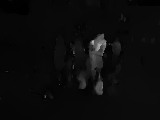

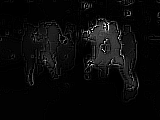

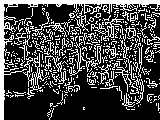

15


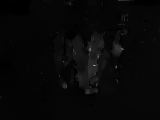

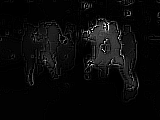

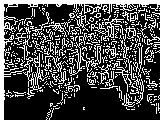

18


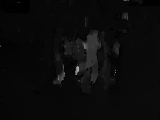

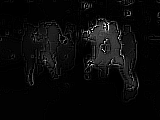

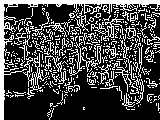

21


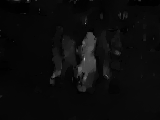

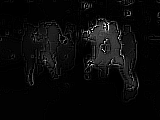

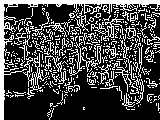

24


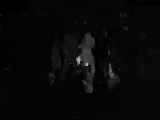

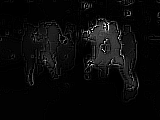

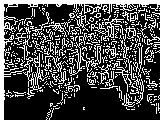

27


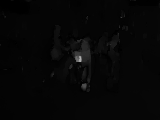

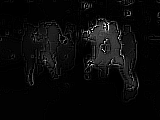

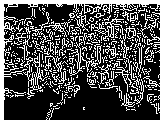

30


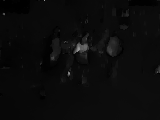

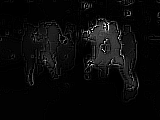

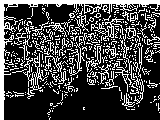

33


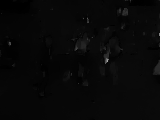

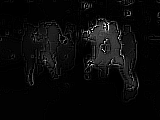

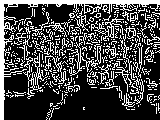

36


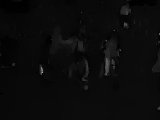

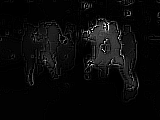

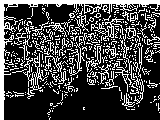

39


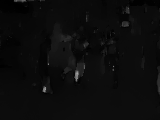

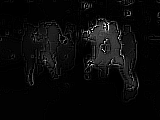

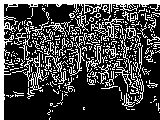

42


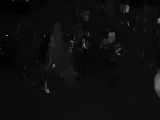

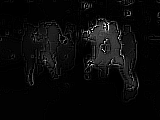

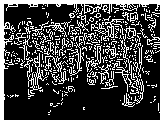

45


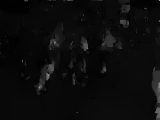

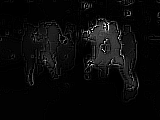

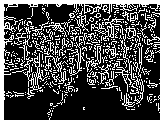

48


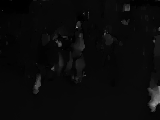

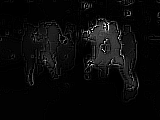

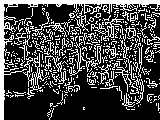

51


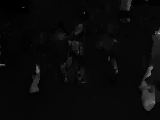

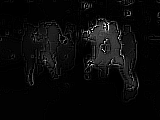

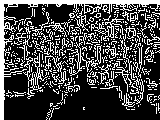

54


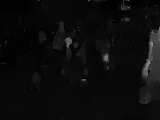

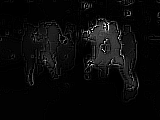

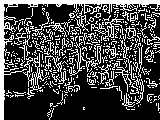

57


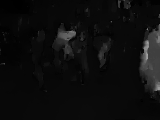

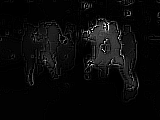

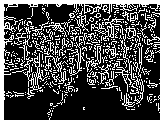

60


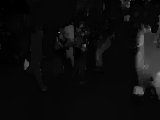

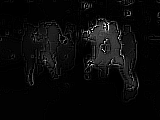

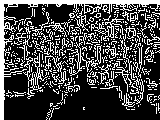

63


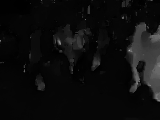

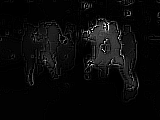

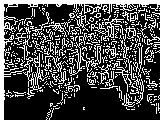

66


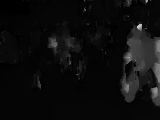

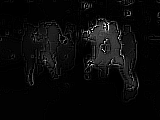

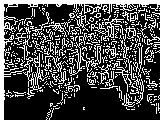

69


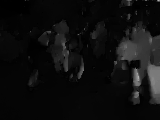

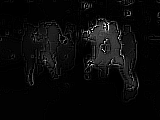

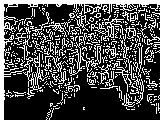

72


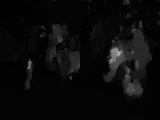

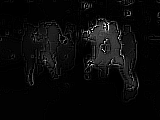

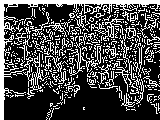

75


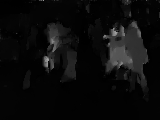

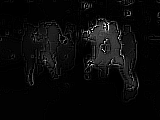

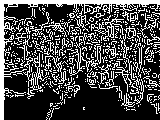

78


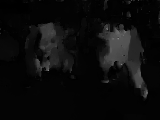

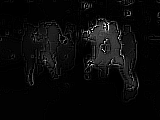

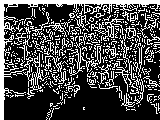

81


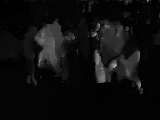

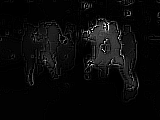

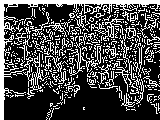

84


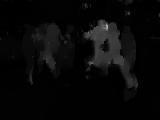

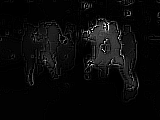

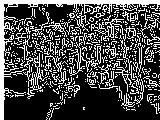

87


In [33]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
 
 
cap = cv2.VideoCapture("/content/drive/My Drive/Machine Lol/Data/cobaoluc/8.mp4")
ret, frame1 = cap.read()
frame1 = cv2.resize(frame1, (160, 120))
cv2_imshow(frame1)
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
s = 1
while(cap.isOpened()):
    ret, frame2 = cap.read()

    if not ret:
      break;
    if s % 3 == 0:
      frame2 = cv2.resize(frame2, (160, 120))
      #Trích xuất dòng quang từ 2 frame gần nhau
      next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
      optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()
      flow = optical_flow.calc(prvs, next, None)
      mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
      hsv[...,0] = ang*180/np.pi/2
      nom = np.zeros((160,120))
      hsv[...,2] = cv2.normalize(mag,nom,0,255,cv2.NORM_MINMAX)
      bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
      gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

      #Tăng độ nét cho ảnh dòng quang
      bilateral = cv2.bilateralFilter(gray,5,5, 5)
      kernel = np.array([[-1, -1, -1], [-1, 1, -1], [-1, -1, -1]])
      sharpen = cv2.filter2D(gray, -1, kernel)
      
      
      #gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
      #gray1 = gray[...,::-1]
      cv2_imshow(gray)
      cv2_imshow(bilateral1)
      
      #guidefilter = cv2.ximgproc.guidedFilter(gray, gray1, radius=1, eps=0.016, dDepth=-1)
      
      #cv2_imshow(guidefilter)
      v = np.median(bilateral)
      sigma = 0.33
      lower = int(max(0, (1.0 - sigma) * v))
      upper = int(min(255, (1.0 + sigma) * v))
      canny = cv2.Canny(bilateral1, lower, upper)

      kernel = np.zeros((5,5),np.uint8)
      opening = cv2.morphologyEx(canny, cv2.MORPH_OPEN, kernel)
      temp = opening.copy()
      h, w = temp.shape[:2]
      mask = np.zeros((h+2, w+2), np.uint8)
      cv2.floodFill(temp, mask, (1,1), 255);

      lapday = opening | temp
      #cv2_imshow(bgr)
      cv2_imshow(lapday)
      print(s)
      #cv2_imshow(gray)
      prvs = next.copy()
    s += 1